# Milestone Project 1: Food Vision Big

## Check GPU

Google Colab offers free GPUs, however not all of them are compatible with mixed precision.

Google Colab offers:
* K80
* P100
* Tesla T4

Knowing this, in order to use mixed precision training we need access to a Tesla T4 or if we're using our own hardware, our GPU needs a score of 7.0+

In [1]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f36a3d67-7b2b-efd2-e28c-3c32ebfbb2b0)


## Get helper functions

In [2]:
# Download Helper function
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-02-27 14:38:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-02-27 14:38:54 (104 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use Tensorflow Datasets to Download Data

If you want to get an overview of Tensorflwo Dataset (TFDS) read the guide:
https://www.tensorflow.org/datasets

In [4]:
# Get tensorflow Datasets
import tensorflow_datasets as tfds

datasets_list = tfds.list_builders()
print("food101" in datasets_list)

True


In [5]:
# Load in the data (take 5-6 min in Google Colab)
(train_data, test_data), ds_info = tfds.load(name= 'food101',
                                             split= ['train', 'validation'],
                                             shuffle_files= True,
                                             as_supervised= True, # data gets returned in tuple format (data, labels)
                                             with_info= True # provides the meta data along with the dataset
                                             )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteMO62MY/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteMO62MY/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Exploring the Food101 data from Tensorflow Datasets

To become one with the dataset, we need:
* Class names
* The shape of the dataset (height, width, channels)
* The datatype of our input data
* What the labels look like (Label encoded or One-hot encoded)
* Do the labels matchup with class names

In [6]:
# Features of Food101 from TFDS
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
train_one_sample = train_data.take(1) # samples are in format (image tensorm, label)

In [9]:
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image Datatype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
  """)


  Image shape: (341, 512, 3)
  Image Datatype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 98
  Class name (str form): tiramisu
  


In [11]:
# What does our image tensor from TFDS's Food101 look like
image

<tf.Tensor: shape=(341, 512, 3), dtype=uint8, numpy=
array([[[  2,   2,   0],
        [  2,   2,   0],
        [  2,   2,   0],
        ...,
        [  0,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  2,   2,   0],
        [  2,   2,   0],
        [  3,   3,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   4,   0]],

       [[  5,   6,   1],
        [  5,   6,   1],
        [  5,   6,   1],
        ...,
        [  1,   3,   0],
        [  0,   4,   0],
        [  0,   5,   1]],

       ...,

       [[143,  75,  10],
        [149,  81,  16],
        [150,  85,  19],
        ...,
        [162,  88,  25],
        [150,  79,  17],
        [135,  65,   5]],

       [[144,  76,  11],
        [152,  84,  19],
        [145,  80,  16],
        ...,
        [126,  60,  12],
        [111,  50,   3],
        [ 95,  37,   0]],

       [[145,  77,  14],
        [150,  82,  19],
        [139,  74,  10],
        ...,
        [ 89,  35,   

In [12]:
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from Tensorflow Datset

(-0.5, 511.5, 340.5, -0.5)

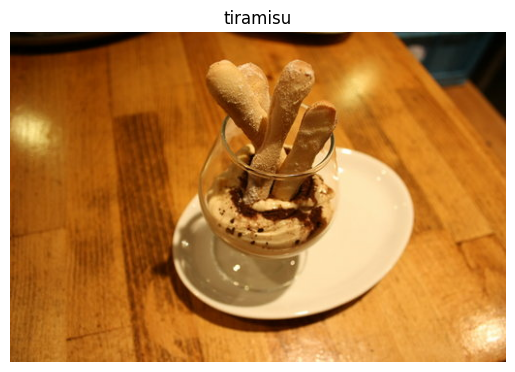

In [13]:
# Plot an image tensor
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False)

## Create preprocessing functions for our data

Neural Networks perform best when the data is in a certain way.

However, not all the data comes like this.

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data

What we know about our data:
* In `uint8` data type
* Compromised of all different tensors
* Not scaled

What we know models like:
* Data in `float32` or `float16` dtype
* For batches, Tensorflow likes all of the tensors within a batch to be of the same size
* Scaled our dataset (between 0 & 1)

With these points in mind we've got a few thing we can tackle with preprocessing function

Since we're going to be using EfficientNetBX pretrained model from tf.keras.applications we don't need to resclae our data

This means our function needs to:
1. Reshape our images to all the same size
2. Convert the dtype of our image tensors from `uint8` to `float32`

In [14]:
# Make a functions for preprocessing images
def preprocess_img (image, label, img_shape= 224):
  """
  Converts image datatype from 'uint8' -> 'float32 and reshapes
  image to (img_shape, img_shape, channels)
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshaping the image
  # image = image/255. # Scale our image not required for EfficientNet
  return tf.cast(image, tf.float32), label # return (float32_image, lable) tuple

In [15]:
# Preprocessing a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing: \n {image[:2]}..., \nShape: {image.shape}, \nDatatype: {image.dtype}")
print(f"Image after preprocessing: \n{preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype: {preprocessed_img.dtype}")

Image before preprocessing: 
 [[[2 2 0]
  [2 2 0]
  [2 2 0]
  ...
  [0 3 0]
  [0 4 0]
  [0 4 0]]

 [[2 2 0]
  [2 2 0]
  [3 3 1]
  ...
  [1 3 0]
  [0 4 0]
  [0 4 0]]]..., 
Shape: (341, 512, 3), 
Datatype: <dtype: 'uint8'>
Image after preprocessing: 
[[[2.         2.         0.        ]
  [2.947226   2.947226   0.947226  ]
  [4.         5.         0.        ]
  ...
  [1.         3.         0.        ]
  [0.01865775 2.757497   0.        ]
  [0.         4.         0.        ]]

 [[4.350446   5.1339283  0.7834821 ]
  [4.566964   5.350446   1.        ]
  [4.783482   5.783482   0.7834821 ]
  ...
  [1.         3.         0.        ]
  [0.7989505  2.7989504  0.        ]
  [0.         4.2798424  0.27984235]]]..., 
Shape: (224, 224, 3), 
Datatype: <dtype: 'float32'>


## Batch & prepare datasets

We're now going to make our data input pipeline run really fast.

In [16]:
# Map preprocessing function to training data
train_data = train_data.map(map_func= preprocess_img, num_parallel_calls= tf.data.AUTOTUNE)

# Shuffle train data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size= 1000).batch(batch_size= 32).prefetch(buffer_size= tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func= preprocess_img, num_parallel_calls= tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Create modelling callbacks

We're going to create a couple of callbacks to help is while our model trains:

* TensorBoard callback to log training results
* ModelCheckpoint callback to save our model's progress after feature extraction

In [111]:
# Create tensorboard callback

checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor= 'val_loss',
                                                      save_best_only= True,
                                                      verbose= 0) # don't print whether the model is saved or not

## Setup Mixed precision training

First and foremost, for deeper understanding of mixed presicion understand it from the documentation

In [19]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("mixed_float16") # set global data policy to mixed precision

In [20]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [21]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top= False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape= input_shape, name= 'input_layer')
#x = layers.Rescaling(1/255.)(inputs)
x = base_model(inputs, training= False)
x = layers.GlobalAveragePooling2D(name= 'global_average_pooling')(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype= tf.float32, name= 'softmax_float32')(x)

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(),
              metrics= ['accuracy'])

16705208/16705208 [==============================] - 1s 0us/step


In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

## Checking layer dtype policies (are we using mixed precision?)

In [23]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:
* `layer.name`: the human readable name of particular layer
* `layer.trainable`: is the layer trainable or not
* `layer.dtype`: the data type a layer stores its variables in
* `layer.dtype_policy`: the data type policy a layer computes on its variable

In [24]:
# Check the dtype policies of EfficientNet
for layer in model.layers[1].layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_1 False float32 <Policy "float32">
rescaling False float32 <Policy "mixed_float16">
normalization False float32 <Policy "mixed_float16">
rescaling_1 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float32 <

In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Fit the feature extraction model

If our goal is to fine-tune a preptrained model, the general order of doing thing is:
1. Build a feature extraction model
2. Fine-tune some of the frozen layers

In [26]:
# Fit feature extraction model with callbacks
history_feature_extraction = model.fit(train_data,
                                       epochs= 3,
                                       steps_per_epoch= len(train_data),
                                       validation_data= test_data,
                                       validation_steps= int(0.15 * len(test_data)),
                                       callbacks= [create_tensorboard_callback("food_vision", "feature_extraction"),
                                                   model_checkpoint])

Saving TensorBoard log files to: food_vision/feature_extraction/20240227-144414
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7149 - accuracy: 0.5827

2368/2368 [==============================] - 110s 42ms/step - loss: 1.7149 - accuracy: 0.5827 - val_loss: 1.1197 - val_accuracy: 0.7039
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1994 - accuracy: 0.6880

2368/2368 [==============================] - 98s 41ms/step - loss: 1.1994 - accuracy: 0.6880 - val_loss: 1.0239 - val_accuracy: 0.7264
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0535 - accuracy: 0.7238

2368/2368 [==============================] - 98s 41ms/step - loss: 1.0535 - accuracy: 0.7238 - val_loss: 0.9918 - val_accuracy: 0.7262


In [27]:
# Evaluate model on whole test dataset
results_feature_extraction = model.evaluate(test_data)
results_feature_extraction

790/790 [==============================] - 28s 35ms/step - loss: 1.0015 - accuracy: 0.7269


[1.001509189605713, 0.7268911004066467]

## Fine tuning

We've covered a lot of ground so far but since this is a milestone project, its time for you to takeover.

More specifically, your challenge is to complete the TEMPLATE version og 07 to obtain a computer vision model. to beat the DeepFood paper.

In other words, you are going to create Food Vision Big!!

You can find the TEMPLATE notebook in the github

In [63]:
FINE_TUNING_LAYER = -30

In [64]:
# Making the last 5 layers of the base model trainable for fine tuning
base_model.trainable = True

for layer in base_model.layers[:FINE_TUNING_LAYER]:
  layer.trainable = False

for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [65]:
model.compile(loss= 'sparse_categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(),
              metrics= ['accuracy'])

In [66]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [67]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling True
dense True
softmax_float32 True


In [68]:
INIT_EPOCH = len(history_feature_extraction.epoch)
FINE_TUNE_EPOCH = INIT_EPOCH + 5

In [69]:
with tf.device('/device:GPU:0'):
  history_fine_tune_1 = model.fit(train_data,
                                  epochs= FINE_TUNE_EPOCH,
                                  steps_per_epoch= len(train_data),
                                  validation_data= test_data,
                                  validation_steps= int(0.15 * len(test_data)),
                                  initial_epoch= history_feature_extraction.epoch[-1],
                                  callbacks= [create_tensorboard_callback('food_vision', 'fine_tuning_1'),
                                              model_checkpoint])

Saving TensorBoard log files to: food_vision/fine_tuning_1/20240227-172811
Epoch 3/8
2368/2368 [==============================] - ETA: 0s - loss: 0.3882 - accuracy: 0.8813

2368/2368 [==============================] - 128s 49ms/step - loss: 0.3882 - accuracy: 0.8813 - val_loss: 0.9840 - val_accuracy: 0.7704
Epoch 4/8
2368/2368 [==============================] - ETA: 0s - loss: 0.2319 - accuracy: 0.9280

2368/2368 [==============================] - 114s 48ms/step - loss: 0.2319 - accuracy: 0.9280 - val_loss: 1.0631 - val_accuracy: 0.7595
Epoch 5/8
2367/2368 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9361

2368/2368 [==============================] - 114s 48ms/step - loss: 0.2000 - accuracy: 0.9361 - val_loss: 1.2859 - val_accuracy: 0.7508
Epoch 6/8
2368/2368 [==============================] - ETA: 0s - loss: 0.1778 - accuracy: 0.9463

2368/2368 [==============================] - 114s 48ms/step - loss: 0.1778 - accuracy: 0.9463 - val_loss: 1.2591 - val_accuracy: 0.7595
Epoch 7/8
2367/2368 [============================>.] - ETA: 0s - loss: 0.1792 - accuracy: 0.9470

2368/2368 [==============================] - 114s 48ms/step - loss: 0.1792 - accuracy: 0.9470 - val_loss: 1.3091 - val_accuracy: 0.7572
Epoch 8/8
2367/2368 [============================>.] - ETA: 0s - loss: 0.1820 - accuracy: 0.9489

2368/2368 [==============================] - 115s 48ms/step - loss: 0.1820 - accuracy: 0.9489 - val_loss: 1.3881 - val_accuracy: 0.7524


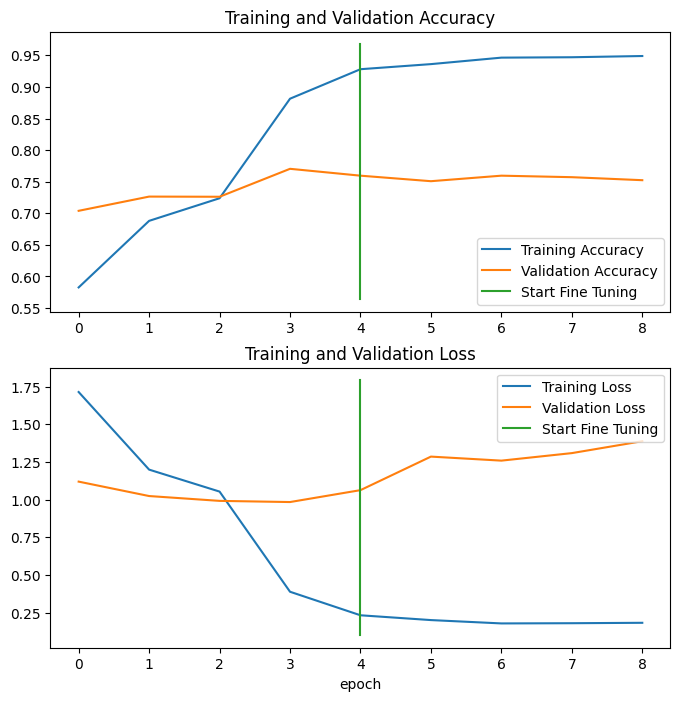

In [70]:
compare_historys(history_feature_extraction,
                 history_fine_tune_1)

## Including Data Augmentation

The normal model without data augmentation is not breaking the Food Vision Model's baseline.

Let's try to include the data augmentation and check what will be the performance of the model

In [71]:
# Creating data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    layers.RandomZoom(0.2)
], name= 'data_augmentation_layer')

In [72]:
# Making the last 5 layers of the base model trainable for fine tuning
base_model.trainable = False

In [73]:
# Create functional model
inputs = layers.Input(shape= input_shape, name= 'input_layer')
#x = layers.Rescaling(1/255.)(inputs)
x = data_augmentation(inputs)
x = base_model(x, training= False)
x = layers.GlobalAveragePooling2D(name= 'global_average_pooling')(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype= tf.float32, name= 'softmax_float32')(x)

model_data_augmentation = tf.keras.Model(inputs, outputs)

# Compile the model
model_data_augmentation.compile(loss= 'sparse_categorical_crossentropy',
              optimizer= tf.keras.optimizers.Adam(),
              metrics= ['accuracy'])

In [74]:
model_data_augmentation.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (S  (None, None, None, 3)     0         
 equential)                                                      
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                           

In [75]:
for layer in model_data_augmentation.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 False
global_average_pooling True
dense_2 True
softmax_float32 True


In [76]:
with tf.device('/device:GPU:0'):
  history_data_augmentation_feature_extraction = model_data_augmentation.fit(train_data,
                          epochs= 5,
                          steps_per_epoch= len(train_data),
                          validation_data = test_data,
                          validation_steps= int(0.15 * len(test_data)),
                          callbacks= [create_tensorboard_callback('food_vision', 'data_augmentation_feature_extraction'),
                                      model_checkpoint])

Saving TensorBoard log files to: food_vision/data_augmentation_feature_extraction/20240227-173952
Epoch 1/5
2368/2368 [==============================] - ETA: 0s - loss: 1.3782 - accuracy: 0.6604

2368/2368 [==============================] - 131s 51ms/step - loss: 1.3782 - accuracy: 0.6604 - val_loss: 0.8852 - val_accuracy: 0.7632
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 0.9482 - accuracy: 0.7424

2368/2368 [==============================] - 119s 50ms/step - loss: 0.9482 - accuracy: 0.7424 - val_loss: 0.8695 - val_accuracy: 0.7775
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 0.8441 - accuracy: 0.7660

2368/2368 [==============================] - 114s 48ms/step - loss: 0.8441 - accuracy: 0.7660 - val_loss: 0.8770 - val_accuracy: 0.7757
Epoch 4/5
2368/2368 [==============================] - ETA: 0s - loss: 0.8071 - accuracy: 0.7749

2368/2368 [==============================] - 113s 47ms/step - loss: 0.8071 - accuracy: 0.7749 - val_loss: 0.8824 - val_accuracy: 0.7749
Epoch 5/5
2368/2368 [==============================] - ETA: 0s - loss: 0.7657 - accuracy: 0.7844

2368/2368 [==============================] - 113s 48ms/step - loss: 0.7657 - accuracy: 0.7844 - val_loss: 0.9141 - val_accuracy: 0.7709


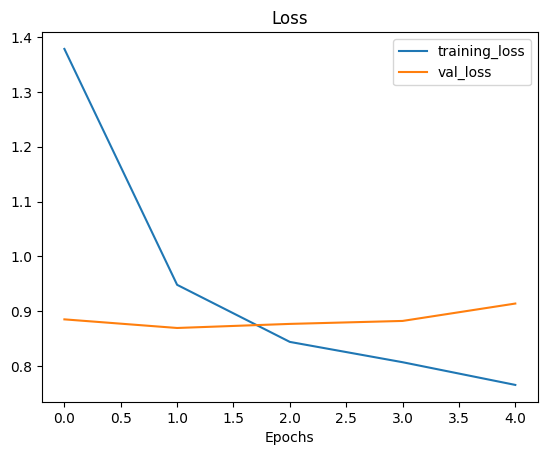

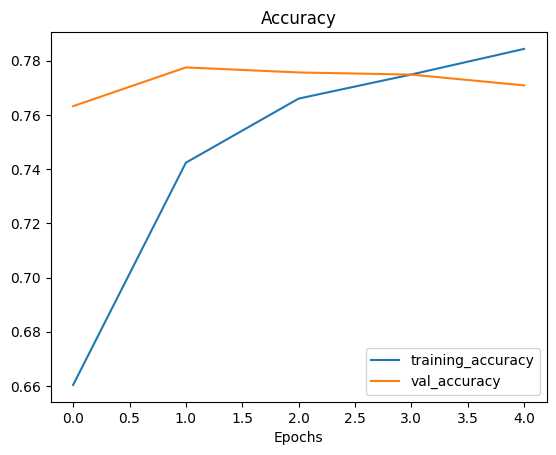

In [77]:
plot_loss_curves(history_data_augmentation_feature_extraction)

## Fine tuning the data augmentation model

In [78]:
# Making the last 5 layers of the base model trainable for fine tuning
base_model.trainable = True

for layer in base_model.layers[:FINE_TUNING_LAYER]:
  layer.trainable = False

for i, layer in enumerate(base_model.layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [79]:
model_data_augmentation.compile(loss= 'sparse_categorical_crossentropy',
                           optimizer= tf.keras.optimizers.Adam(),
                           metrics= ['accuracy'])

In [80]:
for layer in model_data_augmentation.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_pooling True
dense_2 True
softmax_float32 True


In [81]:
for layer in model_data_augmentation.layers[2].layers:
  print(layer.name, layer.trainable)

input_1 False
rescaling False
normalization False
rescaling_1 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_proj

In [82]:
with tf.device('/device:GPU:0'):
  history_data_augmentation_fine_tuning = model_data_augmentation.fit(train_data,
                              epochs= FINE_TUNE_EPOCH,
                              steps_per_epoch= len(train_data),
                              validation_data= test_data,
                              validation_steps= int(0.15 * len(test_data)),
                              initial_epoch= history_data_augmentation_feature_extraction.epoch[-1],
                              callbacks= [create_tensorboard_callback('food_vision', 'data_augmentation_fine_tuning'),
                                        model_checkpoint])

Saving TensorBoard log files to: food_vision/data_augmentation_fine_tuning/20240227-174943
Epoch 5/8
2368/2368 [==============================] - ETA: 0s - loss: 0.8494 - accuracy: 0.7610

2368/2368 [==============================] - 146s 56ms/step - loss: 0.8494 - accuracy: 0.7610 - val_loss: 0.9178 - val_accuracy: 0.7526
Epoch 6/8
2368/2368 [==============================] - ETA: 0s - loss: 0.7442 - accuracy: 0.7876

2368/2368 [==============================] - 125s 53ms/step - loss: 0.7442 - accuracy: 0.7876 - val_loss: 1.0069 - val_accuracy: 0.7405
Epoch 7/8
2368/2368 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.8041

2368/2368 [==============================] - 126s 53ms/step - loss: 0.6797 - accuracy: 0.8041 - val_loss: 0.9697 - val_accuracy: 0.7558
Epoch 8/8
2368/2368 [==============================] - ETA: 0s - loss: 0.6179 - accuracy: 0.8183

2368/2368 [==============================] - 124s 52ms/step - loss: 0.6179 - accuracy: 0.8183 - val_loss: 1.0268 - val_accuracy: 0.7492


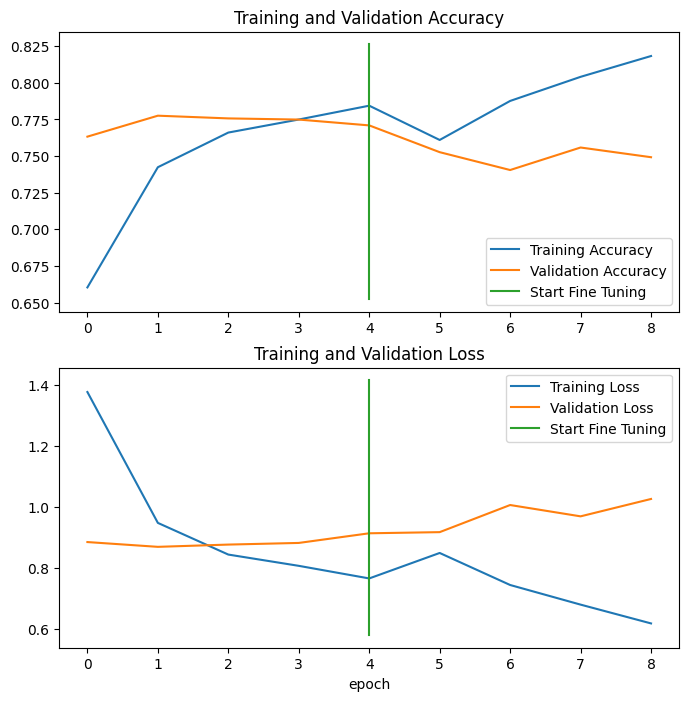

In [83]:
compare_historys(history_data_augmentation_feature_extraction,
                 history_data_augmentation_fine_tuning)

In [84]:
model.evaluate(test_data)

790/790 [==============================] - 28s 36ms/step - loss: 1.1797 - accuracy: 0.7499


[1.1796618700027466, 0.7499009966850281]

In [85]:
model_data_augmentation.evaluate(test_data)

790/790 [==============================] - 28s 36ms/step - loss: 1.0437 - accuracy: 0.7500


[1.0437088012695312, 0.7500197887420654]

In [86]:
pred_prob = model_data_augmentation.predict(test_data, verbose= 1)

790/790 [==============================] - 27s 33ms/step


In [87]:
len(pred_prob)

25250

In [88]:
pred_prob.shape

(25250, 101)

In [89]:
len(test_data)

790

In [90]:
for pred_class in tf.argmax(pred_prob, axis= 1)[:10]:
  print(class_names[pred_class])

spaghetti_carbonara
lobster_bisque
cup_cakes
pulled_pork_sandwich
dumplings
poutine
pizza
peking_duck
french_fries
french_fries


In [91]:
pred_classes = tf.argmax(pred_prob, axis= 1)

In [92]:
y_labels = []
for image, label in test_data.unbatch():
  y_labels.append(label.numpy())

y_labels[:5]

[83, 44, 27, 79, 16]

## Evaluating our model using various techniques

In [93]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import itertools

In [94]:
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Changed ###
  plt.xticks(rotation= 70, fontsize= text_size)
  plt.yticks(fontsize= text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [95]:
make_confusion_matrix(y_true= y_labels,
                      y_pred= pred_classes,
                      classes= class_names,
                      figsize= (100, 100),
                      text_size= 20,
                      savefig= True)

In [96]:
from sklearn.metrics import classification_report

classification_report_data_aygmentation = classification_report(y_labels, pred_classes)

In [97]:
print(classification_report_data_aygmentation)

              precision    recall  f1-score   support

           0       0.01      0.01      0.01       250
           1       0.01      0.00      0.01       250
           2       0.00      0.00      0.00       250
           3       0.01      0.02      0.01       250
           4       0.02      0.02      0.02       250
           5       0.00      0.00      0.00       250
           6       0.00      0.00      0.00       250
           7       0.01      0.01      0.01       250
           8       0.02      0.02      0.02       250
           9       0.01      0.00      0.00       250
          10       0.01      0.01      0.01       250
          11       0.00      0.00      0.00       250
          12       0.02      0.02      0.02       250
          13       0.01      0.02      0.01       250
          14       0.00      0.00      0.00       250
          15       0.01      0.01      0.01       250
          16       0.01      0.01      0.01       250
          17       0.01    

In [98]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip


# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

--2024-02-27 18:03:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.218.207, 142.251.31.207, 142.250.145.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.218.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  14.3MB/s    in 1.1s    

2024-02-27 18:03:26 (14.3 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloa

In [104]:
# Load and evaluate downloaded GS model
loaded_model = tf.keras.models.load_model("downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")

In [109]:
for layer in loaded_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable, layer.dtype)

input_layer True float32
efficientnetb0 True float32
pooling_layer True float32
dense True float32
softmax_float32 True float32


In [110]:
for layer in loaded_model.layers[1].layers:
  print(layer.name, layer.trainable)

input_1 True
rescaling True
normalization True
stem_conv_pad True
stem_conv True
stem_bn True
stem_activation True
block1a_dwconv True
block1a_bn True
block1a_activation True
block1a_se_squeeze True
block1a_se_reshape True
block1a_se_reduce True
block1a_se_expand True
block1a_se_excite True
block1a_project_conv True
block1a_project_bn True
block2a_expand_conv True
block2a_expand_bn True
block2a_expand_activation True
block2a_dwconv_pad True
block2a_dwconv True
block2a_bn True
block2a_activation True
block2a_se_squeeze True
block2a_se_reshape True
block2a_se_reduce True
block2a_se_expand True
block2a_se_excite True
block2a_project_conv True
block2a_project_bn True
block2b_expand_conv True
block2b_expand_bn True
block2b_expand_activation True
block2b_dwconv True
block2b_bn True
block2b_activation True
block2b_se_squeeze True
block2b_se_reshape True
block2b_se_reduce True
block2b_se_expand True
block2b_se_excite True
block2b_project_conv True
block2b_project_bn True
block2b_drop True
bloc

In [107]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [108]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 31s 37ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0880998373031616, 0.7066138386726379]

## Creating more callbacks

In [112]:
# Creating early stop callback to monitor for validation loss value
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                  patience= 3)

# Creating Reduction LR callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= 'val_loss',
                                                 factor= 0.2,
                                                 patience= 2,
                                                 verbose= 1,
                                                 min_lr= 1e-7)

In [113]:
loaded_model.compile(loss= 'sparse_categorical_crossentropy',
                     optimizer= tf.keras.optimizers.Adam(learning_rate= 0.0001),
                     metrics= ['accuracy'])

In [117]:
history_fine_tuning_all_layers = loaded_model.fit(train_data,
                                                  epochs= 100,
                                                  steps_per_epoch= len(train_data),
                                                  validation_data= test_data,
                                                  validation_steps= int(0.15 * len(test_data)),
                                                  callbacks= [create_tensorboard_callback('food_vision', 'fine_tune_all_layers'),
                                                              model_checkpoint,
                                                              early_stopping,
                                                              reduce_lr])

Saving TensorBoard log files to: food_vision/fine_tune_all_layers/20240228-070059
Epoch 1/100
2368/2368 [==============================] - 375s 142ms/step - loss: 0.9213 - accuracy: 0.7522 - val_loss: 0.8072 - val_accuracy: 0.7765 - lr: 1.0000e-04
Epoch 2/100
2368/2368 [==============================] - 340s 143ms/step - loss: 0.5786 - accuracy: 0.8401 - val_loss: 0.7746 - val_accuracy: 0.7879 - lr: 1.0000e-04
Epoch 3/100
2368/2368 [==============================] - 307s 129ms/step - loss: 0.3284 - accuracy: 0.9064 - val_loss: 0.8316 - val_accuracy: 0.7868 - lr: 1.0000e-04
Epoch 4/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1725 - accuracy: 0.9491
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 307s 129ms/step - loss: 0.1725 - accuracy: 0.9491 - val_loss: 0.9349 - val_accuracy: 0.7929 - lr: 1.0000e-04
Epoch 5/100
2368/2368 [==============================] - 307s 129ms/step - loss: 0.0351 - 

In [119]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 29s 37ms/step - loss: 1.0608 - accuracy: 0.7998


[1.0607597827911377, 0.799841582775116]

## Changing the feature extraction

We tried to fine tune the entire base model by unfreezing them. Let's try other base line model EfficientNetB4

In [121]:
base_model_1 = tf.keras.applications.EfficientNetB4(include_top= False)
base_model_1.trainable = False

inputs = layers.Input(shape= input_shape, name= 'input_layer')
x = base_model_1(inputs)
x = layers.GlobalAveragePooling2D(name= 'global_average_pooling_layer')(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype= tf.float32, name= 'softmax_float32')(x)

model_B4 = tf.keras.Model(inputs, outputs)

In [122]:
model_B4.compile(loss= 'sparse_categorical_crossentropy',
                 optimizer= tf.keras.optimizers.Adam(),
                 metrics= ['accuracy'])

In [125]:
history_B4_feature_extraction = model_B4.fit(train_data,
                                             epochs= 100,
                                             steps_per_epoch= len(train_data),
                                             validation_data= test_data,
                                             validation_steps= len(test_data),
                                             callbacks= [create_tensorboard_callback('food_vision', 'B4_feature_extraction_model'),
                                                         model_checkpoint,
                                                         early_stopping,
                                                         reduce_lr])

Saving TensorBoard log files to: food_vision/B4_feature_extraction_model/20240228-081418
Epoch 1/100
2368/2368 [==============================] - 291s 116ms/step - loss: 1.8572 - accuracy: 0.5399 - val_loss: 1.2621 - val_accuracy: 0.6655 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - 273s 115ms/step - loss: 1.3959 - accuracy: 0.6363 - val_loss: 1.1580 - val_accuracy: 0.6912 - lr: 0.0010
Epoch 3/100
2368/2368 [==============================] - 273s 115ms/step - loss: 1.2621 - accuracy: 0.6672 - val_loss: 1.1280 - val_accuracy: 0.6948 - lr: 0.0010
Epoch 4/100
2368/2368 [==============================] - 273s 115ms/step - loss: 1.1760 - accuracy: 0.6884 - val_loss: 1.0925 - val_accuracy: 0.7033 - lr: 0.0010
Epoch 5/100
2368/2368 [==============================] - 274s 116ms/step - loss: 1.1105 - accuracy: 0.7024 - val_loss: 1.0798 - val_accuracy: 0.7063 - lr: 0.0010
Epoch 6/100
2368/2368 [==============================] - 274s 115ms/step - loss: 1.0553 - accuracy: 0

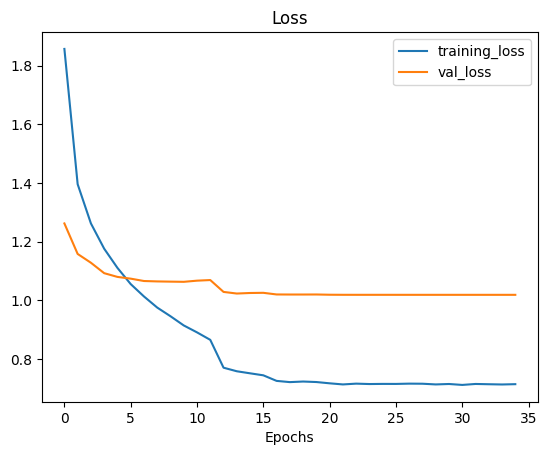

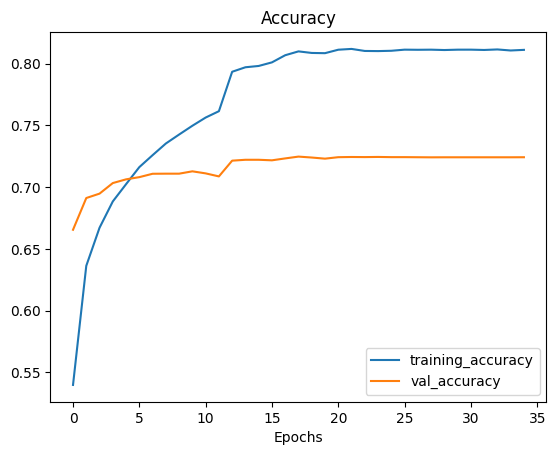

In [126]:
plot_loss_curves(history_B4_feature_extraction)

In [127]:
# Evaluate the model
model_B4.evaluate(test_data)

790/790 [==============================] - 64s 80ms/step - loss: 1.0186 - accuracy: 0.7242


[1.0186269283294678, 0.7242376208305359]

## Fine tuning B4 model

In [150]:
FINE_TUNING_LAYER = -10

In [151]:
base_model_1.trainable = True
for layer in base_model_1.layers[:FINE_TUNING_LAYER]:
  layer.trainable = False

In [152]:
for layer in base_model_1.layers:
  print(layer.name, layer.trainable)

input_3 False
rescaling_4 False
normalization_2 False
rescaling_5 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block1b_dwconv False
block1b_bn False
block1b_activation False
block1b_se_squeeze False
block1b_se_reshape False
block1b_se_reduce False
block1b_se_expand False
block1b_se_excite False
block1b_project_conv False
block1b_project_bn False
block1b_drop False
block1b_add False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
b

In [153]:
model_B4.compile(loss= 'sparse_categorical_crossentropy',
                 optimizer= tf.keras.optimizers.Adam(),
                 metrics= ['accuracy'])

In [154]:
for layer in model_B4.layers:
  print(layer.name, layer.trainable)

input_layer True
efficientnetb4 True
global_average_pooling_layer True
dense_3 True
softmax_float32 True


In [155]:
history_b4_fine_tuning = model_B4.fit(train_data,
             epochs= 100,
             steps_per_epoch= len(train_data),
             validation_data= test_data,
             validation_steps= int(0.15 * len(test_data)),
             callbacks= [create_tensorboard_callback('food_vision', 'B4_fine_tuning'),
                         model_checkpoint,
                         early_stopping,
                         reduce_lr])

Saving TensorBoard log files to: food_vision/B4_fine_tuning/20240228-112023
Epoch 1/100
2368/2368 [==============================] - 243s 95ms/step - loss: 1.3841 - accuracy: 0.6383 - val_loss: 1.0876 - val_accuracy: 0.7058 - lr: 0.0010
Epoch 2/100
2368/2368 [==============================] - 225s 95ms/step - loss: 1.0450 - accuracy: 0.7133 - val_loss: 1.0953 - val_accuracy: 0.7177 - lr: 0.0010
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8518 - accuracy: 0.7572
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 226s 95ms/step - loss: 0.8519 - accuracy: 0.7571 - val_loss: 1.1012 - val_accuracy: 0.7132 - lr: 0.0010
Epoch 4/100
2368/2368 [==============================] - 225s 95ms/step - loss: 0.4870 - accuracy: 0.8629 - val_loss: 0.9532 - val_accuracy: 0.7542 - lr: 2.0000e-04
Epoch 5/100
2368/2368 [==============================] - 226s 95ms/step - loss: 0.3753 - accuracy: 0.8965 - val_

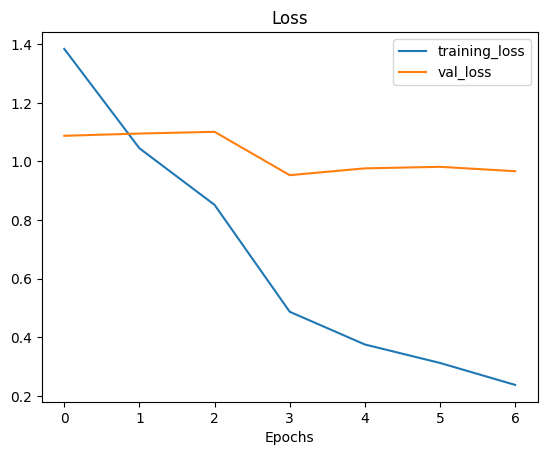

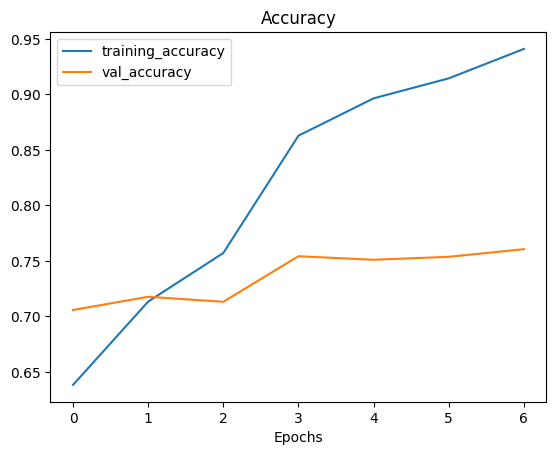

In [156]:
plot_loss_curves(history_b4_fine_tuning)